In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import rnnInput as inp
from matplotlib import pyplot as plt
from tensorflow.contrib import learn
import time as t
from lstm import lstm_model
from sklearn.metrics import mean_squared_error

#from lstm import generate_data, lstm_model, rnn_data,load_csvdata
LOG_DIR = None
TIMESTEPS = 5
RNN_LAYERS = [{'num_units': 5}]
DENSE_LAYERS = None
TRAINING_STEPS = 1000
PRINT_STEPS = TRAINING_STEPS / 5
BATCH_SIZE = 10


config = tf.ConfigProto()
config.allow_soft_placement=True
config.log_device_placement=True
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.Session(config=config)

#inicializacao do regressor com os dados da rede
regressor = learn.Estimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS), 
                           model_dir=LOG_DIR)


In [2]:
#leitura dos dados
data = pd.read_csv('./data/'+'EHM01044.txt', sep="\t")
df = pd.DataFrame(data, columns = ['Temp'])
df=df[15:]
df=df.reset_index(drop=True)

In [3]:
X, y = inp.load_csvdata(df, TIMESTEPS, seperate=False)
regressor = learn.Estimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS),
                            model_dir=LOG_DIR)

validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                     every_n_steps=100)
regressor.fit(X['train'], y['train'], 
              monitors=[validation_monitor], 
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

C:\Users\freak\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Estimator(params=None)

C:\Users\freak\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


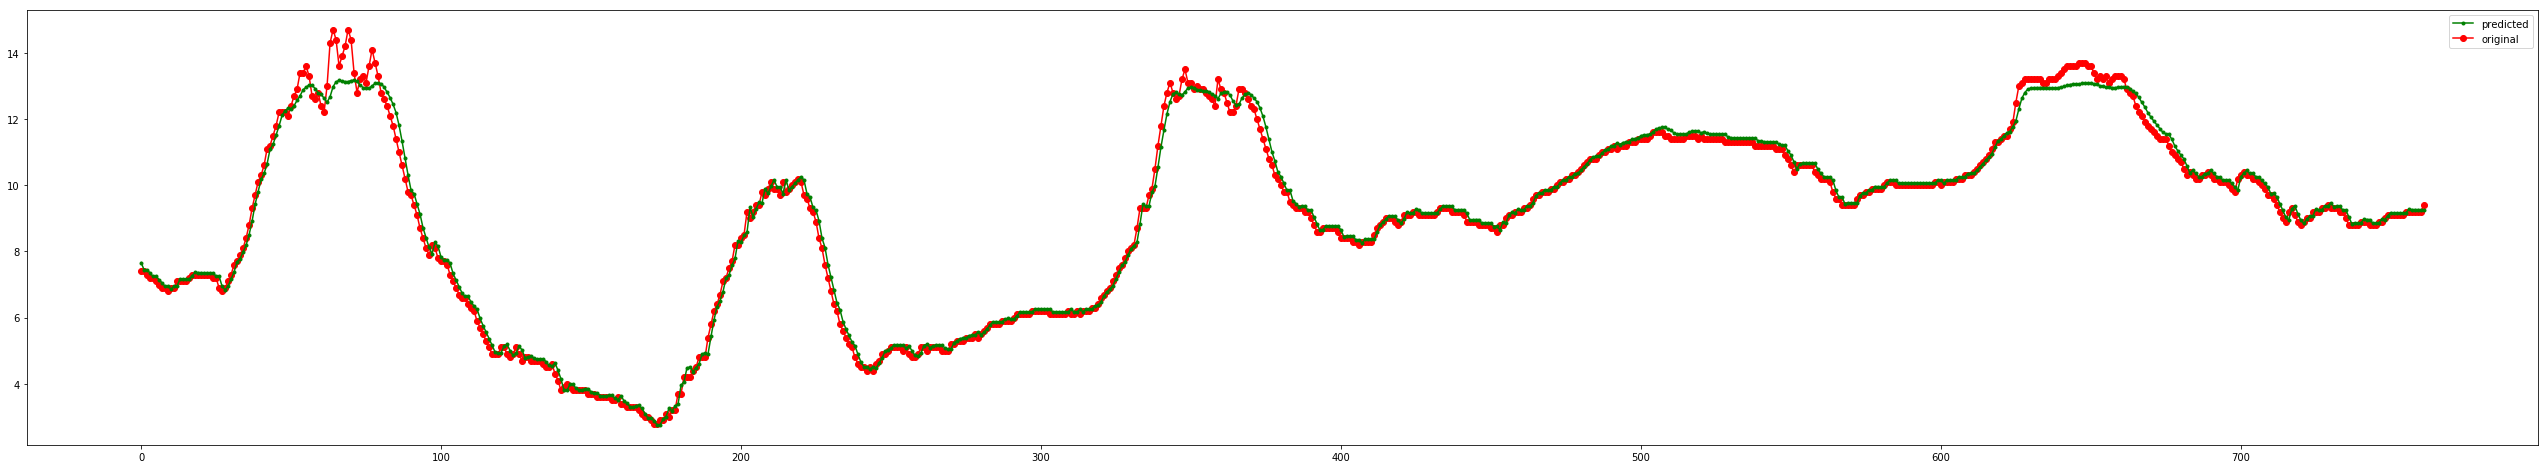

In [4]:
#geracao de predict
predicted = regressor.predict(X['test'])
predictedArr = np.array(list(predicted))
predictedArr.shape=-1,1
#predictedDataFrame=pd.DataFrame(predictedArr)
plt.figure(figsize=(45,8))
plot_test, = plt.plot(y['test'], label='original', marker='o', color='g')
plot_predicted, = plt.plot(predictedArr, label='predicted',marker='.', color='r')
plt.legend(handles=[plot_predicted, plot_test])

In [6]:
#teste geracao predict completo
def predizer(qtd,inicio):
    #a funcao requer um inicio com o length minimo de TIMESTEPS+1
    inicial=pd.DataFrame(inicio[inicio.size-TIMESTEPS-1:])
    inicial.reset_index(drop=True)
    qtd+=TIMESTEPS
    data_test=inp.rnn_data(inicial,TIMESTEPS)
    Tpredicted = regressor.predict(data_test)
    predictedArr = np.array(list(Tpredicted))
    entraRaw = inicial.append(pd.DataFrame(predictedArr),ignore_index=True)
    entraRaw=entraRaw[entraRaw.size-TIMESTEPS-1:] 
    entraRaw=entraRaw.reset_index(drop=True)
    entrada = inp.rnn_data(entraRaw,TIMESTEPS)
    qtd-=1
    i=0
    tempoInicial = t.time()
    tempot = tempoInicial
    retorno = pd.DataFrame(inicio)
    retorno = retorno.append(pd.DataFrame(predictedArr))
    while(qtd>TIMESTEPS):
        i=i+1
        with tf.device('/gpu:0'):
            Tpredicted = regressor.predict(entrada)
        predictedArr = np.array(list(Tpredicted))
        entraRaw = entraRaw.append(pd.DataFrame(predictedArr),ignore_index=True)
        entraRaw=entraRaw[entraRaw.size-TIMESTEPS-1:]
        entraRaw=entraRaw.reset_index(drop=True)
        entrada = inp.rnn_data(entraRaw,TIMESTEPS)
        retorno = retorno.append(pd.DataFrame(predictedArr),ignore_index=True)
        qtd-=1
        tempoTrain = t.time() - tempot
        tempot = t.time()
        print("passo n.: ",i,"tempo do passo: ",tempoTrain)
    tempoTotal = t.time() - tempoInicial
    print("tempo total da predição: ",tempoTotal)
    retorno.reset_index(drop=True)
    return retorno

    

In [25]:
#exemplo predict recursivo
#é necessario gerar uma amostra inicial do tamanho de TIMESTEPS+1
k = predictedArr[predictedArr.size-TIMESTEPS-21:predictedArr.size-20]
print('valores iniciais para o predict {}'.format(k))
print("iniciando predict recursivo")
entraPredizer = pd.DataFrame(k)
pred=predizer(20,entraPredizer)


valores iniciais para o predict [[ 9.04794025]
 [ 8.84589005]
 [ 8.88667774]
 [ 8.88696003]
 [ 8.88939857]
 [ 9.00964642]]


C:\Users\freak\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


passo n.:  1 tempo do passo:  2.444317102432251
passo n.:  2 tempo do passo:  2.4903171062469482
passo n.:  3 tempo do passo:  2.6863620281219482
passo n.:  4 tempo do passo:  2.575329303741455
passo n.:  5 tempo do passo:  2.6208300590515137
passo n.:  6 tempo do passo:  2.5693469047546387
passo n.:  7 tempo do passo:  2.420788526535034
passo n.:  8 tempo do passo:  2.460820436477661
passo n.:  9 tempo do passo:  2.2457833290100098
passo n.:  10 tempo do passo:  2.7448537349700928
passo n.:  11 tempo do passo:  2.5658276081085205
passo n.:  12 tempo do passo:  2.4353108406066895
passo n.:  13 tempo do passo:  2.3873050212860107
passo n.:  14 tempo do passo:  2.55631947517395
passo n.:  15 tempo do passo:  2.218283176422119
passo n.:  16 tempo do passo:  2.7378499507904053
passo n.:  17 tempo do passo:  2.5218284130096436
passo n.:  18 tempo do passo:  2.5288166999816895
passo n.:  19 tempo do passo:  2.6669342517852783
tempo total da predição:  47.87722396850586


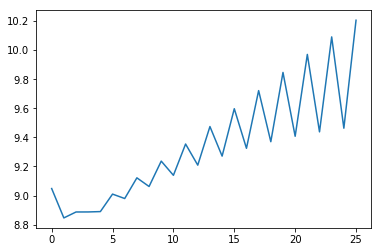

In [26]:
plt.plot(pred)